# **I. Data Pre-Processing**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install structlog

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.2/67.2 kB 2.7 MB/s eta 0:00:00


In [3]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import structlog
from typing import Any
import plotly.express as px

In [4]:
def load_data(path: Path) -> pd.DataFrame:
    """Load data from a directory with multiple CSV files or a single CSV file.

    Args:
        path (Path): Path to a CSV file or a directory containing CSV files.

    Returns:
        pd.DataFrame: Data loaded from the CSV file(s).
    """
    path = Path(path)

    if path.is_file():
        # If the path is a file, read the single CSV file
        return pd.read_csv(path)
    elif path.is_dir():
        # If the path is a directory, list all CSV files in the directory
        csv_files = list(path.glob("*.csv"))

        # Read each CSV file and concatenate into a single DataFrame
        dataframes = [pd.read_csv(csv_file) for csv_file in csv_files]

        # Concatenate all DataFrames
        combined_df = pd.concat(dataframes, ignore_index=True)

        return combined_df
    else:
        raise ValueError("The provided path is neither a file nor a directory.")

In [5]:
def clean_data(data: pd.DataFrame) -> pd.DataFrame:
    """Clean the data and return a cleaned DataFrame.

    Criteria:
    - Remove duplicates
    - Remove rows with missing values

    Args:
        data (pd.DataFrame): Data to be cleaned

    Returns:
        pd.DataFrame: Cleaned data
    """
    # Remove duplicates
    data_cleaned = data.drop_duplicates()

    # Remove rows with missing values
    data_cleaned = data_cleaned.dropna()

    # Keep only the required columns: 'customer_id', 'product_id', and 'date'
    data_cleaned = data_cleaned[['customer_id', 'product_id', 'date']]

    return data_cleaned

In [6]:
def preprocess_data(data: pd.DataFrame) -> pd.DataFrame:
    """Preprocess the data and return a preprocessed DataFrame.

    Criteria:
    - Convert date column to datetime
    - Sort the data by date

    Args:
        data (pd.DataFrame): Data to be preprocessed

    Returns:
        pd.DataFrame: Preprocessed data
    """
    # Convert 'date' column to datetime
    data['date'] = pd.to_datetime(data['date'])

    # Sort the data by 'date'
    data = data.sort_values(by='date').reset_index(drop=True)

    return data

In [7]:
def aggregate_data_monthly(data: pd.DataFrame) -> pd.DataFrame:
    """Aggregate data into monthly summaries.

    Args:
        data (pd.DataFrame): Preprocessed transaction data.

    Returns:
        pd.DataFrame: Aggregated monthly data with customer_id, month, year, and total_transactions.
    """
    # Extract year and month from the date column
    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month

    # Create a dataframe with all possible combinations of customer_id, year, and month
    all_customers = data['customer_id'].unique()
    date_range = pd.date_range(
        data['date'].min(),
        data['date'].max() + pd.DateOffset(months=1), freq='M')
    all_months_years = pd.DataFrame(
        [(customer, date.month, date.year) for customer in all_customers for date in date_range],
        columns=['customer_id', 'month', 'year'])

    # Aggregate transactions by customer, month, and year
    monthly_agg = data.groupby(['customer_id', 'year', 'month']).size().reset_index()

    # Rename the column after reset_index
    monthly_agg.columns = pd.Index(['customer_id', 'year', 'month', 'total_transactions'])

    # Merge to ensure all combinations of customer_id and months are included
    aggregated_data = pd.merge(all_months_years, monthly_agg, on=['customer_id', 'year', 'month'], how='left')

    # Fill missing transactions with 0
    aggregated_data['total_transactions'].fillna(0, inplace=True)
    aggregated_data['total_transactions'] = aggregated_data['total_transactions'].astype(int)

    return aggregated_data

# **II. Feature Engineering**

In [8]:
def add_lag_features(df: pd.DataFrame, lag_months: int) -> pd.DataFrame:
    """Add lag features to the aggregated data.

    Args:
        df (pd.DataFrame): Data with monthly transactions.
        lag_months (int): The number of lag features to create (e.g., 3 for 1 month ago, 2 months ago, etc.).

    Returns:
        pd.DataFrame: Dataframe with added lag features.
    """
    # Sort values by customer_id, year, and month to ensure correct lagging
    df = df.sort_values(by=['customer_id', 'year', 'month'])

    # Create lag features for each lag_month
    for lag in range(1, lag_months + 1):
        df[f'transactions_lag_{lag}'] = df.groupby('customer_id')['total_transactions'].shift(lag)

    # Fill NaN values that appear due to the shifting with 0
    df.fillna(0, inplace=True)

    return df

In [9]:
def add_moving_average_features(df: pd.DataFrame, windows=[3, 6]) -> pd.DataFrame:
    """
    Add moving average features for total transactions over time for each customer.

    Args:
        df (pd.DataFrame): The aggregated data containing monthly transactions for each customer.
        windows (list): List of window sizes for calculating moving averages (default: [3, 6] months).

    Returns:
        pd.DataFrame: DataFrame with moving average features added.
    """
    # Ensure the data is sorted by customer, year, and month
    df = df.sort_values(by=['customer_id', 'year', 'month'])

    # Create moving averages for each window size
    for window in windows:
        df[f'moving_avg_{window}'] = df.groupby('customer_id')['total_transactions'].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean()
        )

    return df

In [10]:
def calculate_recency(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate the recency in months for each customer, which is the number of months since their last actual transaction.

    Args:
        df (pd.DataFrame): Dataframe containing customer transactions with 'year', 'month', and 'total_transactions' columns.

    Returns:
        pd.DataFrame: Updated dataframe with a 'recency' column indicating the number of months since the last actual transaction.
    """
    # Ensure the data is sorted by customer_id, year, and month
    df = df.sort_values(by=['customer_id', 'year', 'month'])

    # Combine year and month into a 'year_month' column for easier date comparison
    df['year_month'] = df['year'] * 12 + df['month']  # Convert year and month into a numeric scale (year * 12 + month)

    # Initialize last_transaction to NaN initially for all customers
    df['last_transaction_year_month'] = np.nan

    # Iterate over each customer to calculate recency based on non-zero transactions
    for customer_id, customer_data in df.groupby('customer_id'):
        # Track the last time a transaction happened
        last_transaction_time = np.nan

        # Iterate through the customer's data in chronological order
        for idx, row in customer_data.iterrows():
            # Check if the customer made any transaction in the current month
            if row['total_transactions'] > 0:
                # If this is a valid transaction month, calculate the recency based on the last transaction
                if not pd.isna(last_transaction_time):
                    df.at[idx, 'last_transaction_year_month'] = last_transaction_time

                # Update the last transaction time to the current year-month
                last_transaction_time = row['year_month']

    # Calculate recency by subtracting the last transaction month from the current month
    df['recency'] = df['year_month'] - df['last_transaction_year_month']

    # Fill NaN values in recency (first transactions) with a large number (e.g., 9999)
    df['recency'].fillna(0, inplace=True)

    # Explicitly cast 'recency' column to integer
    df['recency'] = df['recency'].astype(int)

    # Drop temporary columns
    df.drop(columns=['year_month', 'last_transaction_year_month'], inplace=True)

    return df

In [11]:
def add_recency_frequency_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add recency and frequency features to the data for each customer.

    Args:
        df (pd.DataFrame): The aggregated data containing monthly transactions for each customer.

    Returns:
        pd.DataFrame: DataFrame with recency and frequency features added.
    """
    # Calculate Recency: Add recency column based on actual transaction months
    df = calculate_recency(df)

    # Calculate Frequency: Average number of transactions per month for each customer
    df['frequency'] = df.groupby('customer_id')['total_transactions'].transform('mean')

    return df

In [12]:
def add_customer_behavior_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add customer behavior features: lifetime value and transaction growth rate.

    Args:
        df (pd.DataFrame): The aggregated data containing monthly transactions for each customer.

    Returns:
        pd.DataFrame: DataFrame with customer behavior features added.
    """
    # Calculate Customer Lifetime Value: Total transactions for each customer over their entire history
    df['customer_lifetime_value'] = df.groupby('customer_id')['total_transactions'].transform('sum')

    # Calculate Transaction Growth Rate: Percent change in transactions compared to the previous month
    df['transaction_growth_rate'] = df.groupby('customer_id')['total_transactions'].pct_change().fillna(0)

    # Replace infinite values with np.nan or capped values
    df['transaction_growth_rate'].replace([np.inf, -np.inf], np.nan, inplace=True)

    # Optionally: Fill NaN values with 0, or you can use more advanced imputation strategies later
    df['transaction_growth_rate'].fillna(0, inplace=True)

    return df

In [13]:
def mean_encode_customer_id(data: pd.DataFrame) -> pd.DataFrame:
    """
    Perform mean encoding for the 'customer_id' column by calculating the
    average number of transactions per customer across months.

    Args:
        data (pd.DataFrame): Preprocessed data containing customer transactions

    Returns:
        pd.DataFrame: Dataframe with mean encoding for customer_id
    """
    # Calculate the mean number of transactions for each customer
    customer_mean = data.groupby('customer_id')['total_transactions'].mean().reset_index()
    customer_mean.columns = pd.Index(['customer_id', 'customer_mean_encoded_transactions'])

    # Merge the mean encoded feature back into the original data
    data = pd.merge(data, customer_mean, on='customer_id', how='left')

    return data

In [14]:
def add_cyclical_month_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add cyclical representation for the 'month' column using sine and cosine transformations.

    Args:
        df (pd.DataFrame): The aggregated data containing monthly transactions for each customer.

    Returns:
        pd.DataFrame: DataFrame with cyclical month features added.
    """
    # Create sine and cosine transformations for the month column
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    # Round values to a precision that matches the expected results
    df['month_sin'] = df['month_sin'].round(3)
    df['month_cos'] = df['month_cos'].round(3)

    return df

In [15]:
def add_numerical_year_feature(df: pd.DataFrame) -> pd.DataFrame:
    """
    Convert the 'year' feature into a scaled numerical format for machine learning models.

    Args:
        df (pd.DataFrame): The data containing the 'year' feature.

    Returns:
        pd.DataFrame: DataFrame with a scaled 'year' feature.
    """
    # Scale the 'year' feature between 0 and 1 or between a specific range (min/max normalization)
    min_year = df['year'].min()
    max_year = df['year'].max()

    if min_year == max_year:
        # If all years are the same, set year_scaled to 0
        df['year_scaled'] = 0
    else:
        # Normalizing year between 0 and 1
        df['year_scaled'] = (df['year'] - min_year) / (max_year - min_year)

    return df

In [28]:
def encode_features(df: pd.DataFrame, categorical_columns: list) -> pd.DataFrame:
    """One-hot encode categorical features.

    Args:
        df (pd.DataFrame): DataFrame containing the data.
        categorical_columns (list): List of categorical columns to be one-hot encoded.

    Returns:
        pd.DataFrame: DataFrame with one-hot encoded features.
    """
    # Initialize OneHotEncoder from scikit-learn
    encoder = OneHotEncoder(sparse_output=False)

    # Fit and transform the categorical columns
    encoded = encoder.fit_transform(df[categorical_columns])

    # Create a DataFrame with encoded values
    encoded_df = pd.DataFrame(
        encoded,
        columns=encoder.get_feature_names_out(categorical_columns),
        index=df.index
    )

    # Convert the encoded columns to integer type
    encoded_df = encoded_df.astype(int)

    # Drop the original categorical columns and join the one-hot encoded columns
    df = df.drop(columns=categorical_columns).join(encoded_df)

    return df

In [18]:
def create_smart_features(data: pd.DataFrame) -> pd.DataFrame:
    """
    Create smart features by applying various feature engineering techniques such as aggregation, lag features,
    moving averages, recency and frequency features, customer behavior features, mean encoding,
    and cyclical month features.

    Args:
        data (pd.DataFrame): DataFrame containing the original data with customer transaction details.

    Returns:
        pd.DataFrame: DataFrame with engineered features.
    """
    # Step 1: Aggregate data into monthly summaries
    aggregated_data = aggregate_data_monthly(data)

    # Step 2: Add lag features (e.g., create 3 months of lag features)
    lag_months = 3  # Example for 3-month lag
    data_with_lag = add_lag_features(aggregated_data, lag_months=lag_months)

    # Step 3: Add moving average features (e.g., 3-month and 6-month moving averages)
    moving_average_windows = [3, 6]  # Example windows
    data_with_moving_avg = add_moving_average_features(data_with_lag, windows=moving_average_windows)

    # Step 4: Add recency and frequency features
    data_with_recency_frequency = add_recency_frequency_features(data_with_moving_avg)

    # Step 5: Add customer behavior features (lifetime value and transaction growth rate)
    data_with_customer_behavior = add_customer_behavior_features(data_with_recency_frequency)

    # Step 6: Add mean encoding for customer_id
    data_with_mean_encoding = mean_encode_customer_id(data_with_customer_behavior)

    # Step 7: Add cyclical month features (sine and cosine transformations)
    data_with_cyclical_month = add_cyclical_month_features(data_with_mean_encoding)

    # Step 8: Add numerical year feature (scale year between 0 and 1)
    final_data = add_numerical_year_feature(data_with_cyclical_month)

    return final_data

In [19]:
def filter_data_by_range(data: pd.DataFrame, start: tuple, end: tuple) -> pd.DataFrame:
    """
    Filter data based on the start and end dates provided.

    Args:
        data (pd.DataFrame): The preprocessed data containing 'year' and 'month'.
        start (tuple): Start date as (year, month).
        end (tuple): End date as (year, month).

    Returns:
        pd.DataFrame: Filtered data within the specified date range.
    """
    start_year, start_month = start
    end_year, end_month = end

    filtered_data =  data[((data['year'] > start_year) |
                           ((data['year'] == start_year) & (data['month'] >= start_month))) &
                          ((data['year'] < end_year) |
                           ((data['year'] == end_year) & (data['month'] <= end_month)))]

    # Reset the index here
    return filtered_data.reset_index(drop=True)

In [20]:
def split_data(data: pd.DataFrame, train_start: tuple, train_end: tuple,
               val_start: tuple, val_end: tuple, test_start: tuple, test_end: tuple):
    """
    Split the data into training, validation, and test sets based on the provided date ranges.

    Args:
        data (pd.DataFrame): The preprocessed and feature-engineered data.
        train_start (tuple): Start of the training period (year, month).
        train_end (tuple): End of the training period (year, month).
        val_start (tuple): Start of the validation period (year, month).
        val_end (tuple): End of the validation period (year, month).
        test_start (tuple): Start of the test period (year, month).
        test_end (tuple): End of the test period (year, month).

    Returns:
        x_train, y_train, x_val, y_val, x_test, y_test: Data split into features and targets for each set.
    """

    # Filter data for the training, validation, and test periods
    train_data = filter_data_by_range(data, train_start, train_end)
    val_data = filter_data_by_range(data, val_start, val_end)
    test_data = filter_data_by_range(data, test_start, test_end)

    # Split the training data into features (X) and target (y)
    x_train = train_data.drop(columns=['total_transactions'])
    y_train = train_data['total_transactions']

    # Split the validation data into features (X) and target (y)
    x_val = val_data.drop(columns=['total_transactions'])
    y_val = val_data['total_transactions']

    # Split the test data into features (X) and target (y)
    x_test = test_data.drop(columns=['total_transactions'])
    y_test = test_data['total_transactions']

    return x_train, y_train, x_val, y_val, x_test, y_test

In [21]:
# Load CSV files
data = load_data(Path("/content/drive/MyDrive/MACHINE_LEARNING/MISSION_DATACHEF/dataset/"))

# Clean the data
cleaned_data = clean_data(data)

# Preprocess the data
preprocessed_data = preprocess_data(cleaned_data)

# Create the smart features
time_series_features = create_smart_features(preprocessed_data)

In [26]:
# # Apply the encode_features function
# encoded_data = encode_features(time_series_features, ["year"])

In [ ]:
# Dividing the dataset into Training, Validation, and Test Set
x_train, y_train, x_val, y_val, x_test, y_test = split_data(
    time_series_features, (2017, 1), (2018, 10), (2018, 11), (2019, 1), (2019, 2), (2019, 4))

# Copying the test set in another variable for performing prediction
test_dataset = x_test

# Print after the Data Split is completed
print("Data split complete.")

Data split complete.


In [ ]:
# Drop the Columns "customer_id", "month", and "year"
x_train = x_train.drop(columns=["customer_id"], errors='ignore')
x_val = x_val.drop(columns=["customer_id"], errors='ignore')
x_test = x_test.drop(columns=["customer_id"], errors='ignore')

In [27]:
# output_path = "/content/drive/MyDrive/MACHINE_LEARNING/MISSION_DATACHEF/dataset/old/encoded_data.csv"
# encoded_data.to_csv(output_path, index=False)
# print(f"Data successfully exported to {output_path}")

Data successfully exported to /content/drive/MyDrive/MACHINE_LEARNING/MISSION_DATACHEF/dataset/old/encoded_data.csv


# **III. Model Training**

## 3.1 Model Selection

As part of this Take Home Assignemtn (THA), I am personally looking forward to try Random Forest Regression Algorithm

## 3.2 Set Up Evaluation Metrics

In [ ]:
def get_logger(model_name: str) -> structlog.stdlib.BoundLogger:
    """Get a logger instance.

    Args:
        model_name (str): Name of the model

    Returns:
        structlog.stdlib.BoundLogger: Logger instance
    """
    logger = structlog.get_logger()
    logger = logger.bind(model_name=model_name)
    logger.warning(f"Logger is active for the model: {model_name}.")
    return logger

In [ ]:
def log_model_evaluation(logger: structlog.stdlib.BoundLogger, metrics: dict) -> None:
    """Log the evaluation metrics.

    Args:
        logger (structlog.stdlib.BoundLogger): Logger instance
        metrics (dict): Evaluation metrics
    """
    logger.info("Model evaluation metrics", **metrics)
    logger.warning("Model evaluation metrics have been successfully logged.")

In [ ]:
def evaluate_model(model, X_test: pd.DataFrame, y_test: pd.Series, logger: structlog.stdlib.BoundLogger = None) -> None:
    """Evaluate the model using appropriate metrics on the test set.

    Args:
        model: Trained model
        X_test (pd.DataFrame): Test set features
        y_test (pd.Series): Test set actual target values
        logger (structlog.stdlib.BoundLogger, optional): Logger instance

    Returns:
        None
    """
    # Predicting on the test set
    print("Predicting on the test set...")
    y_test_pred = model.predict(X_test)

    # Calculate evaluation metrics
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Print evaluation metrics
    print(f"Mean Absolute Error (MAE): {test_mae:.4f}")
    print(f"Mean Squared Error (MSE): {test_mse:.4f}")
    print(f"R-Squared (R2 Score): {test_r2:.4f}")

    # Create a dictionary of evaluation metrics
    evaluation_metrics = {
        'MAE': test_mae,
        'MSE': test_mse,
        'R2': test_r2
    }

    # Log the metrics if a logger is provided
    if logger:
        log_model_evaluation(logger, evaluation_metrics)

    return None

## 3.3 Hyper-Parameter Tuning

In [ ]:
# Define a function for tracking progress during hyperparameter tuning
def verbose_callback(params, split, score):
    """
    Custom verbose callback to print progress during hyperparameter tuning.

    Args:
        params (dict): The set of hyperparameters being tested.
        split (int): The current split number in cross-validation.
        score (float): The performance score (MAE) for the current split.

    Prints:
        Progress information including the current split, hyperparameters, and the score.
    """
    print(f"Split {split + 1} - Parameters: {params}")
    print(f"Mean Absolute Error (MAE) for this split: {abs(score)}")
    print("-" * 50)

In [ ]:
def hyperparameter_tuning(X: pd.DataFrame, y: pd.Series) -> RandomForestRegressor:
    """Perform hyperparameter tuning for the Random Forest model using TimeSeriesSplit.

    Args:
        X (pd.DataFrame): Features, must contain 'year' and 'month' columns
        y (pd.Series): Target variable

    Returns:
        RandomForestRegressor: Model with best hyperparameters
    """
    # Sort the dataset by year and month before splitting (if not already sorted)
    X = X.sort_values(by=['year', 'month'])
    y = y.loc[X.index]

    # Define the parameter grid
    param_grid = {
        'n_estimators': [100, 200, 500],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False],
        'max_features': ['sqrt', 'log2'],
    }

    # Initialize the Random Forest Regressor
    rf = RandomForestRegressor(random_state=42)

    # TimeSeriesSplit for cross-validation (5 splits)
    tscv = TimeSeriesSplit(n_splits=5)

    # RandomizedSearchCV for hyperparameter tuning
    random_search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_grid,
        n_iter=10,  # Number of parameter settings sampled
        cv=tscv,    # Use TimeSeriesSplit for cross-validation
        verbose=2,  # Set to 2 for detailed progress updates
        n_jobs=-1,  # Use all available cores
        scoring='neg_mean_absolute_error',
        return_train_score=True  # To capture training scores as well
    )

    # Fit the model on the training data
    print("Starting Random Forest hyperparameter tuning...")
    search_results = random_search.fit(X, y)

    # Extract cross-validation results
    cv_results = search_results.cv_results_
    for i in range(len(cv_results['mean_test_score'])):
        params = cv_results['params'][i]
        score = cv_results['mean_test_score'][i]
        split_num = i // 5  # Get the split number
        verbose_callback(params, split_num, score)

    # Print the best parameters and best score
    print("Hyperparameter tuning complete!")
    print("Best Parameters:", search_results.best_params_)
    print(f"Best Score (MAE): {-search_results.best_score_}")  # Convert to positive error

    return search_results.best_estimator_

In [ ]:
# Perform hyperparameter tuning
best_rf_model = hyperparameter_tuning(x_train, y_train)

Starting Random Forest hyperparameter tuning...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Split 1 - Parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 10, 'bootstrap': False}
Mean Absolute Error (MAE) for this split: 6.357767124872682
--------------------------------------------------
Split 1 - Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}
Mean Absolute Error (MAE) for this split: 5.918498394048961
--------------------------------------------------
Split 1 - Parameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}
Mean Absolute Error (MAE) for this split: 5.5216854641489785
--------------------------------------------------
Split 1 - Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': None, 'bootstrap': False}
Mean Absolute Error (MAE) for this split: 5.4815551014576

In [ ]:
# # Dividing the dataset into Training, Validation, and Test Set
# x_train, y_train, x_val, y_val, x_test, y_test = split_data(
#     time_series_features, (2017, 1), (2019, 1), (2018, 11), (2019, 1), (2019, 2), (2019, 4))

# # Copying the test set in another variable for performing prediction
# test_dataset = x_test

# # Print after the Data Split is completed
# print("Data split complete.")

Data split complete.


In [ ]:
# # Drop the Columns "customer_id", "month", and "year"
# x_train = x_train.drop(columns=["customer_id"], errors='ignore')
# x_val = x_val.drop(columns=["customer_id"], errors='ignore')
# x_test = x_test.drop(columns=["customer_id"], errors='ignore')

In [ ]:
def save_model(model: RandomForestRegressor, path: Path) -> None:
    """Save the model to disk.

    Args:
        model (RandomForestRegressor): Model to save
        path (Path): Path to save the model

    Returns:
        None
    """
    # Save the model using joblib
    joblib.dump(model, path)
    print(f"Model saved to {path}")

In [ ]:
def load_model(path: Path) -> Any:
    """Load the model from disk.

    Args:
        path (Path): Path to the model file.

    Returns:
        Any: Model loaded from the given path.
    """
    # Load the model using joblib
    model = joblib.load(path)
    print(f"Model loaded from {path}")
    return model

In [ ]:
save_model(best_rf_model, "/content/drive/MyDrive/MACHINE_LEARNING/MISSION_DATACHEF/trained_model/trained_random_forest_5.joblib")

Model saved to /content/drive/MyDrive/MACHINE_LEARNING/MISSION_DATACHEF/trained_model/trained_random_forest_5.joblib


In [ ]:
# Example usage:
loaded_model = load_model("/content/drive/MyDrive/MACHINE_LEARNING/MISSION_DATACHEF/trained_model/trained_random_forest_5.joblib")

Model loaded from /content/drive/MyDrive/MACHINE_LEARNING/MISSION_DATACHEF/trained_model/trained_random_forest_5.joblib


In [ ]:
# Predicting Accuracy on Validation Set, x_val, and y_val
val_accuracy = evaluate_model(loaded_model, x_test, y_test)

Predicting on the test set...
Mean Absolute Error (MAE): 1.8340
Mean Squared Error (MSE): 103.9938
R-Squared (R2 Score): 0.9276


## 3.4 Model Training

In [ ]:
def train_model(X: pd.DataFrame, y: pd.Series, n_estimators=100, max_depth=None,
                min_samples_split=2, min_samples_leaf=1, bootstrap=True, max_features='sqrt') -> RandomForestRegressor:
    """Train a RandomForest model with specified hyperparameters.

    Args:
        X (pd.DataFrame): Features
        y (pd.Series): Target variable
        n_estimators (int): Number of trees in the forest (default: 100)
        max_depth (int): Maximum depth of the trees (default: None)
        min_samples_split (int): Minimum samples required to split an internal node (default: 2)
        min_samples_leaf (int): Minimum samples required at a leaf node (default: 1)
        bootstrap (bool): Whether to bootstrap samples (default: True)
        max_features (str): Number of features to consider for the best split (default: 'sqrt')

    Returns:
        RandomForestRegressor: Trained RandomForest model
    """
    print("Starting training for Random Forest Regressor...")
    print(f"Hyperparameters - n_estimators: {n_estimators}, max_depth: {max_depth}, "
          f"min_samples_split: {min_samples_split}, min_samples_leaf: {min_samples_leaf}, "
          f"bootstrap: {bootstrap}, max_features: {max_features}")

    start_time = time.time()

    # Initialize and train the Random Forest Regressor
    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        max_features=max_features,
        random_state=42
    )

    # Fit the model on the training data
    rf.fit(X, y)

    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds.")

    return rf

In [ ]:
# Train Random Forest with specific hyperparameters
rf_model = train_model(
           X=x_train,
           y=y_train,
           n_estimators=500,
           max_depth=20,
           min_samples_split=5,
           min_samples_leaf=1,
           bootstrap=False,
           max_features='log2'
)

Starting training for Random Forest Regressor...
Hyperparameters - n_estimators: 500, max_depth: 20, min_samples_split: 5, min_samples_leaf: 1, bootstrap: False, max_features: log2
Training completed in 50.73 seconds.


In [ ]:
# Initialize logger with the model name
logger = get_logger("RandomForestModel")

# Predicting Accuracy on Validation Set, x_val, and y_val
test_accuracy = evaluate_model(rf_model, x_test, y_test, logger)

2024-09-21 07:11:02 [warning  ] Logger is active for the model: RandomForestModel. model_name=RandomForestModel
Predicting on the test set...
Mean Absolute Error (MAE): 2.1451
Mean Squared Error (MSE): 117.3344
R-Squared (R2 Score): 0.9183
2024-09-21 07:11:03 [info     ] Model evaluation metrics       MAE=2.1451343661542914 MSE=117.33435754566217 R2=0.9183146649432969 model_name=RandomForestModel
2024-09-21 07:11:03 [warning  ] Model evaluation metrics have been successfully logged. model_name=RandomForestModel


In [ ]:
save_model(rf_model, "/content/drive/MyDrive/MACHINE_LEARNING/MISSION_DATACHEF/trained_model/trained_random_forest_6.joblib")

Model saved to /content/drive/MyDrive/MACHINE_LEARNING/MISSION_DATACHEF/trained_model/trained_random_forest_6.joblib


## 3.5 Feature Importance

In [ ]:
def get_feature_importance(model, feature_names):
    """
    Extract and prepare feature importance data from the Random Forest model.

    Args:
        model: The trained Random Forest model from which feature importances will be extracted.
        feature_names (list): A list of feature names corresponding to the input features used in training.

    Returns:
        pd.DataFrame: A DataFrame with features and their corresponding importance scores.
    """
    # Get the feature importances from the model
    feature_importances = model.feature_importances_

    # Create a DataFrame for feature importances
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    })

    # Sort the DataFrame by importance
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # # Print feature importance values
    # print("\nFeature Importances:")
    # for _, row in feature_importance_df.iterrows():
    #     print(f"{row['Feature']}: {row['Importance']:.4f}")

    return feature_importance_df

In [ ]:
def plot_feature_importance(feature_importance_df):
    """
    Plot the feature importance using Seaborn.

    Args:
        feature_importance_df (pd.DataFrame): A DataFrame containing features and their corresponding importance scores.
    """
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')

    # Add importance score annotations to the bars
    for index, value in enumerate(feature_importance_df['Importance']):
        plt.text(value, index, f'{value:.4f}', va='center')

    plt.title("Feature Importance")
    plt.xlabel("Importance Score")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.show()

<ipython-input-67-dfc2c476dea9>:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




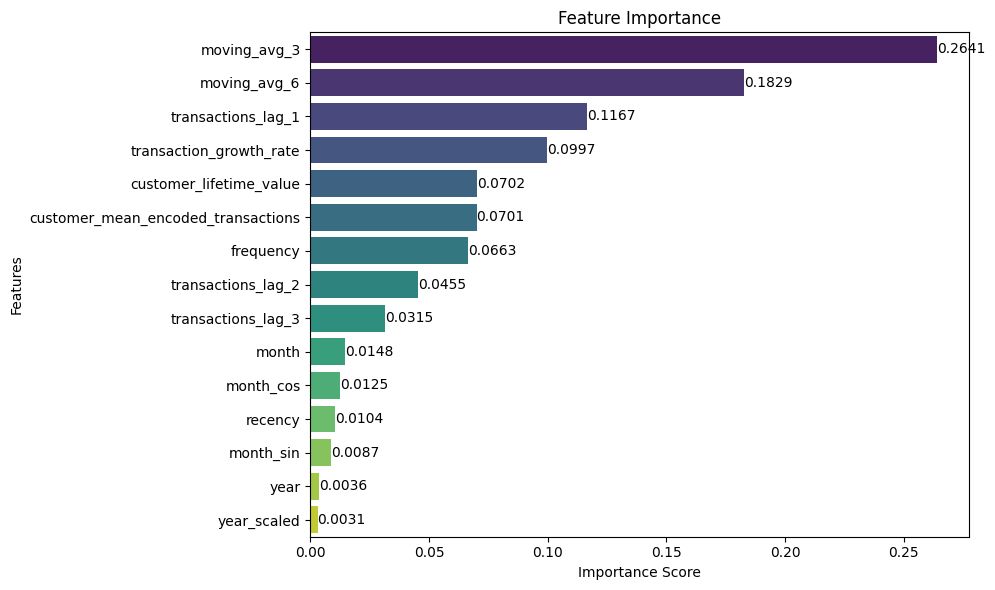

In [ ]:
# Extracting features names from `x_train.columns`
feature_names = x_train.columns

# Get the feature importance data
feature_importance_df = get_feature_importance(loaded_model, feature_names)

# Plot the feature importance
plot_feature_importance(feature_importance_df)

# **IV. Model Prediction**

In [ ]:
# Example usage:
loaded_model = load_model("/content/drive/MyDrive/MACHINE_LEARNING/MISSION_DATACHEF/trained_model/trained_random_forest_6.joblib")

# Assuming you already have trained_model, x_test, and y_test
test_prediction = evaluate_model(loaded_model, x_test, y_test)

Model loaded from /content/drive/MyDrive/MACHINE_LEARNING/MISSION_DATACHEF/trained_model/trained_random_forest_6.joblib
Predicting on the test set...
Mean Absolute Error (MAE): 2.1451
Mean Squared Error (MSE): 117.3344
R-Squared (R2 Score): 0.9183


In [ ]:
def predict(model: RandomForestRegressor, X: pd.DataFrame) -> pd.Series:
    """
    Make predictions using the model.

    Args:
        model (RandomForestRegressor): Trained model to make predictions.
        X (pd.DataFrame): Features to make predictions.

    Returns:
        pd.Series: Predictions made by the model.
    """
    # Perform predictions
    predictions = model.predict(X)
    return pd.Series(predictions, index=X.index)

In [ ]:
def perform_prediction_and_save(model: RandomForestRegressor, test_dataset: pd.DataFrame, y_test: pd.Series, output_file: str) -> pd.DataFrame:
    """
    Perform predictions using the trained model, add predictions, and compare it with true labels,
    and save the result to a CSV.

    Args:
        model (RandomForestRegressor): Trained model to make predictions.
        test_dataset (pd.DataFrame): Test dataset containing customer_id, month, year, and all the independent variables.
        y_test (pd.Series): True labels for comparison.
        output_file (str): File path to save the resulting CSV.

    Returns:
        pd.DataFrame: Test dataset with customer_id, month, year, predictions, and true labels as total_transactions.
    """
    # Store customer_id separately and retain month and year in the dataset
    customer_ids = test_dataset['customer_id'].copy()

    # Drop only customer_id before performing predictions
    X_test = test_dataset.drop(columns=['customer_id'])

    # Perform predictions using the model
    predictions = predict(model, X_test)

    # Create a DataFrame to hold the results with customer_id, month, year, total_transactions (y_test), and predictions
    result_df = pd.DataFrame({
        'customer_id': customer_ids,
        'month': test_dataset['month'],
        'year': test_dataset['year'],
        'total_transactions': y_test.values,  # Rename y_test as total_transactions
        'predictions': predictions
    })

    # Save to CSV
    result_df.to_csv(output_file, index=False)

    return result_df

In [ ]:
def plot_regression_line(y_test, y_test_pred):
    """Scatter plot with regression line comparing actual vs predicted values."""
    plt.figure(figsize=(10, 6))
    sns.regplot(x=y_test, y=y_test_pred, scatter_kws={'s': 50, 'alpha': 0.5}, line_kws={'color': 'red'})
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted (with Regression Line)')
    plt.show()

In [ ]:
def interactive_scatter_plot(y_test, y_test_pred):
    """Interactive scatter plot comparing actual vs predicted values with a regression line."""
    df = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_test_pred
    })

    fig = px.scatter(df, x='Actual', y='Predicted', trendline='ols', title='Actual vs Predicted (with Regression Line) - Interactive')
    fig.update_traces(marker=dict(size=10, line=dict(width=2, color='DarkSlateGrey')))
    fig.update_layout(autosize=False, width=800, height=600, title_x=0.5)
    fig.show()

In [ ]:
# Assuming `test_dataset` is your test set and `y_test` are the ground truth labels.
output_file = "/content/drive/MyDrive/MACHINE_LEARNING/MISSION_DATACHEF/dataset/old/predictions.csv"
result_df = perform_prediction_and_save(rf_model, test_dataset, y_test, output_file)

# Randomly select and print 10 random rows from result_df
print(result_df.sample(n=10))

      customer_id  month  year  total_transactions  predictions
3650      6516369      4  2019                   0     0.000518
3301      5944769      3  2019                   0     0.000180
5562      9355337      2  2019                  27    24.791141
135       1193545      2  2019                   0     0.039546
1518      3207394      2  2019                   0     0.001101
634       1929214      3  2019                   0     0.094093
404       1611027      4  2019                   0     0.032591
3298      5942924      3  2019                  34    45.996555
4835      8221751      4  2019                   0     0.000182
3422      6169481      4  2019                   0     0.000684


In [ ]:
# Extract actual values (y_test) and predicted values (y_test_pred)
y_test = result_df['total_transactions']
y_test_pred = result_df['predictions']

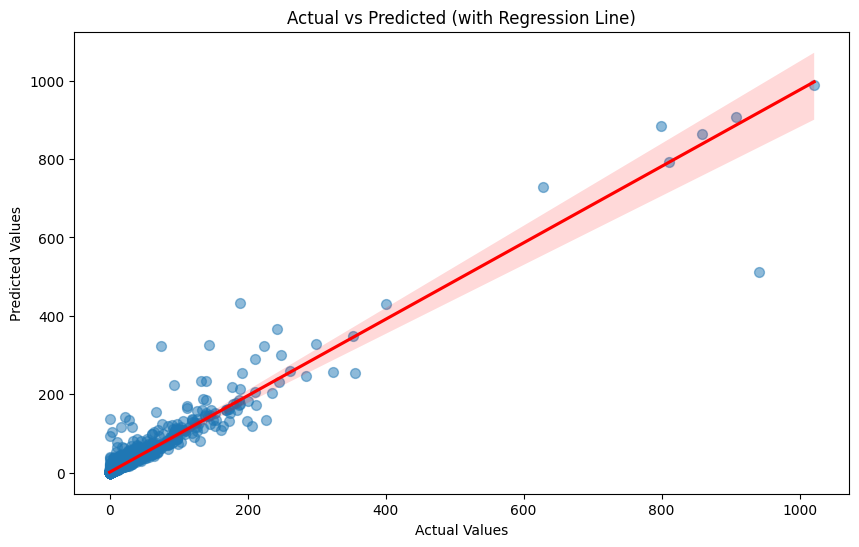

In [ ]:
plot_regression_line(y_test, y_test_pred)

In [ ]:
interactive_scatter_plot(y_test, y_test_pred)

# **The End**